/tmp/ipykernel_18606/3445867758.py:22: RuntimeWarning: divide by zero encountered in log10
  retinex += np.log10(image + 1) - np.log10(blurred + 1)
/tmp/ipykernel_18606/3445867758.py:26: RuntimeWarning: invalid value encountered in cast
  msr_image = exposure.rescale_intensity(msr_image, in_range=(msr_image.min(), msr_image.max()), out_range=(0, 255)).astype(np.uint8)


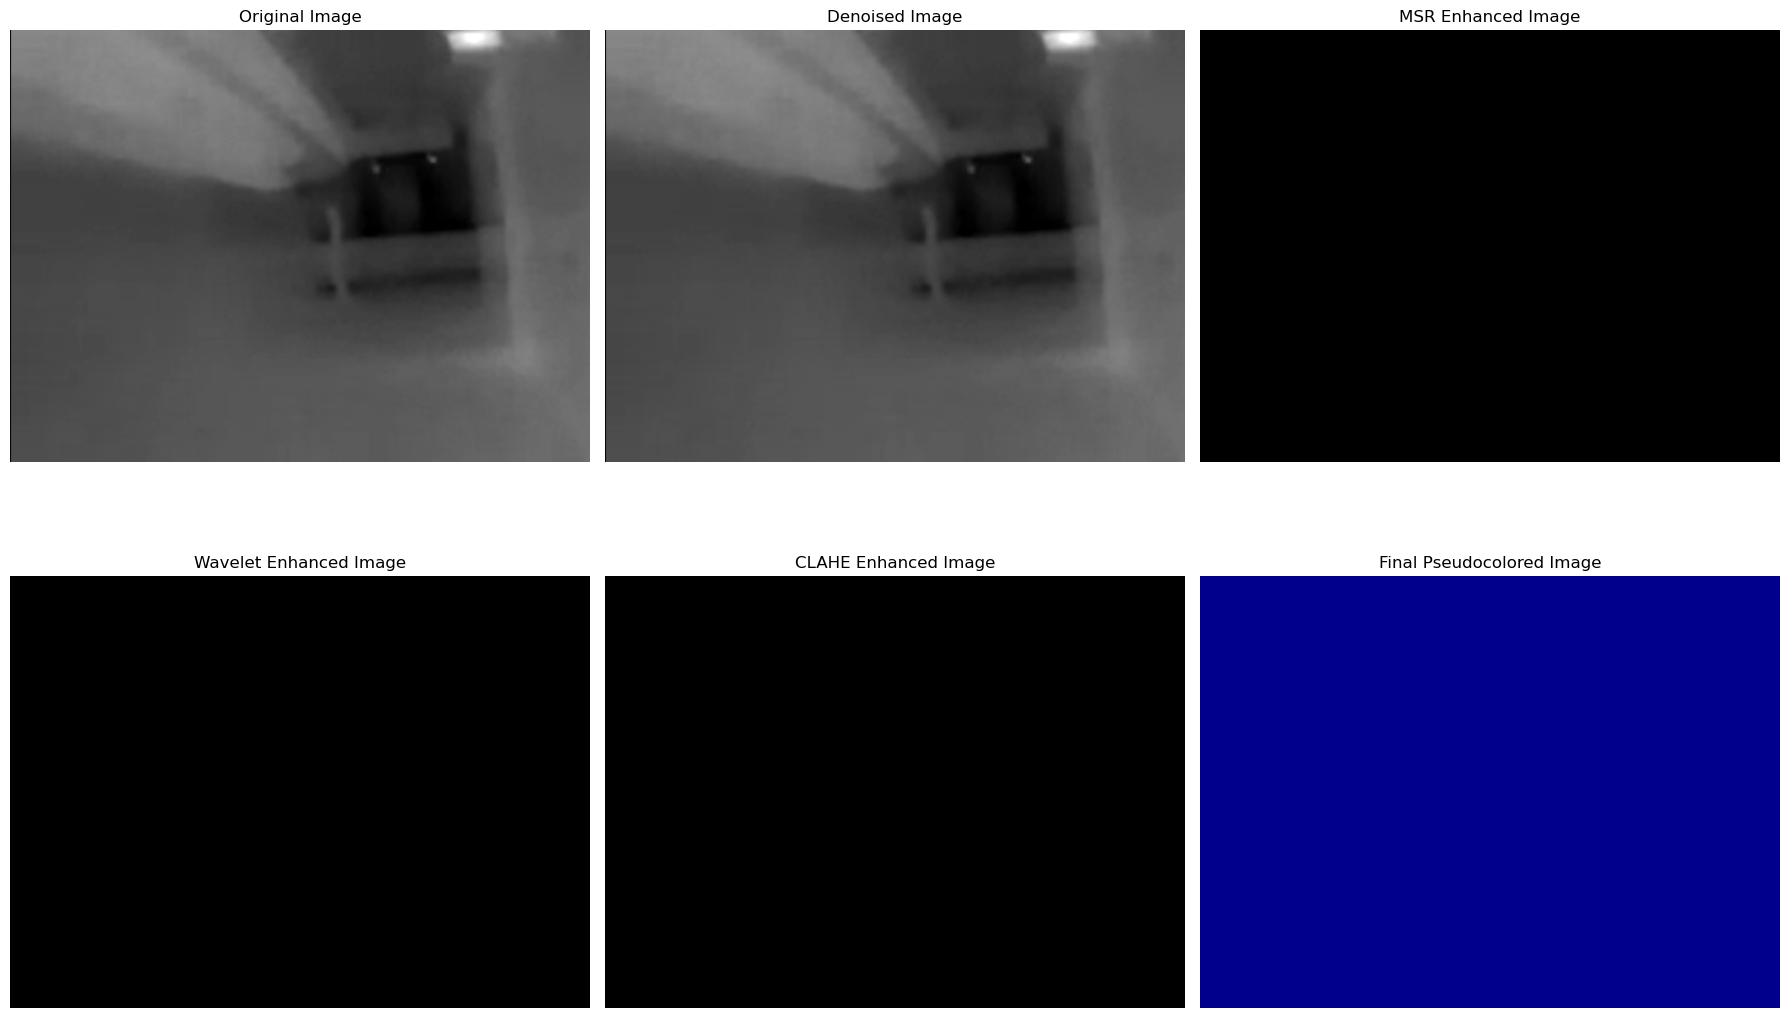

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_float
import pywt

# Load the grayscale thermal image
image = cv2.imread('image.png', cv2.IMREAD_GRAYSCALE)

# Step 1: Noise Reduction (Non-Local Means Denoising)
image_float = img_as_float(image)
sigma_est = np.mean(estimate_sigma(image_float, channel_axis=None))
denoised_image = denoise_nl_means(image_float, h=1.15 * sigma_est, fast_mode=True, patch_size=5, patch_distance=3)

# Step 2: Multi-Scale Retinex (MSR)
def multi_scale_retinex(image, scales=[15, 80, 250]):
    retinex = np.zeros_like(image, dtype=np.float32)
    for scale in scales:
        blurred = cv2.GaussianBlur(image, (0, 0), scale)
        retinex += np.log10(image + 1) - np.log10(blurred + 1)
    return retinex / len(scales)

msr_image = multi_scale_retinex((denoised_image * 255).astype(np.uint8))
msr_image = exposure.rescale_intensity(msr_image, in_range=(msr_image.min(), msr_image.max()), out_range=(0, 255)).astype(np.uint8)

# Step 3: Wavelet Transform-Based Enhancement
def wavelet_enhancement(image):
    # Perform wavelet transform
    coeffs = pywt.dwt2(image, 'haar')
    cA, (cH, cV, cD) = coeffs

    # Enhance coefficients (e.g., amplify high-frequency components)
    cA = cv2.normalize(cA, None, 0, 255, cv2.NORM_MINMAX)
    cH = cv2.normalize(cH, None, 0, 255, cv2.NORM_MINMAX)
    cV = cv2.normalize(cV, None, 0, 255, cv2.NORM_MINMAX)
    cD = cv2.normalize(cD, None, 0, 255, cv2.NORM_MINMAX)

    # Reconstruct the image
    enhanced_image = pywt.idwt2((cA, (cH, cV, cD)), 'haar')
    return enhanced_image

# Ensure the image is in the correct format for wavelet transform
wavelet_input = cv2.normalize(msr_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
wavelet_image = wavelet_enhancement(wavelet_input)

# Normalize the wavelet image to [0, 255] and convert to uint8
wavelet_image_normalized = cv2.normalize(wavelet_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Step 4: Adaptive Histogram Equalization (CLAHE)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_image = clahe.apply(wavelet_image_normalized)

# Step 5: Pseudocoloring
pseudocolored_image = cv2.applyColorMap(clahe_image, cv2.COLORMAP_JET)

# Convert BGR to RGB for Matplotlib
pseudocolored_image_rgb = cv2.cvtColor(pseudocolored_image, cv2.COLOR_BGR2RGB)

# Display the results
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(denoised_image, cmap='gray')
plt.title('Denoised Image')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(msr_image, cmap='gray')
plt.title('MSR Enhanced Image')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(wavelet_image_normalized, cmap='gray')
plt.title('Wavelet Enhanced Image')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(clahe_image, cmap='gray')
plt.title('CLAHE Enhanced Image')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(pseudocolored_image_rgb)
plt.title('Final Pseudocolored Image')
plt.axis('off')

plt.tight_layout()
plt.show()